In [1]:
import cobra
import numpy as np
import pandas as pd
import scipy.sparse
import cvxpy as cp
from equilibrator_api import ComponentContribution, Q_, Reaction
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xml.etree.ElementTree as ET

warnings.filterwarnings("ignore")

# --- CONSTANTS ---
MODEL_PATH = "../fig5/Ecoli/gems/iJO1366.xml"
BASE_RESULTS_PATH = "../fig5/Ecoli/results/teraflux"

CONDITIONS = {
    "ac": "Acetate",
    "fru": "Fructose",
    "gal": "Galactose",
    "glcn": "Gluconate",
    "glc": "Glucose",
    "glyc": "Glycerol",
    "pyr": "Pyruvate",
    "succ": "Succinate"
}

# Thermodynamics
RT = 8.314e-3 * 298.15  # kJ/mol at 25°C
PH = 7.0
IONIC_STRENGTH = "0.15M"

# Solver Settings
SOLVER = cp.CLARABEL  # Fallback: cp.GLPK_MI or cp.OSQP
CONFIDENCE_INTERVAL = 2.58 # 99% Confidence for dG0 uncertainty
FLUX_THRESHOLD = 1e-6
TOLERANCE = 1e-5

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def load_thermo_data(model):
    """
    Pre-calculates standard energies (dG0) and stoichiometric matrix (S)
    for all internal reactions using eQuilibrator.
    """
    print("Initializing eQuilibrator and mapping reactions...")
    cc = ComponentContribution()
    cc.p_h = Q_(PH)
    cc.ionic_strength = Q_(IONIC_STRENGTH)
    
    reaction_ids = []
    eq_reactions = []
    rows, cols, data = [], [], []
    met_to_idx = {}
    metabolite_list = []
    
    # Identify transport reactions to filter later
    transport_rxns = set()

    for rxn in model.reactions:
        # Skip boundary reactions
        if any(x in rxn.id for x in ["EX_", "BIOMASS", "DM_"]): 
            continue
        
        # Check for transport (metabolites in >1 compartment)
        compartments = set(met.compartment for met in rxn.metabolites)
        if len(compartments) > 1:
            transport_rxns.add(rxn.id)
            # We keep mapping it to check dG0, but will skip constraint later
        
        # Map to eQuilibrator
        eq_stoich = {}
        is_mapped = True
        for met, coeff in rxn.metabolites.items():
            base_id = met.id.rsplit('_', 1)[0]
            compound = cc.ccache.get_compound(f"bigg:{base_id}")
            if not compound:
                 kegg = met.annotation.get("kegg.compound")
                 if kegg: 
                     kegg_id = kegg[0] if isinstance(kegg, list) else kegg
                     compound = cc.ccache.get_compound(f"kegg:{kegg_id}")
            
            if not compound: 
                is_mapped = False
                break
            eq_stoich[compound] = coeff
            
        if is_mapped:
            r_idx = len(reaction_ids)
            reaction_ids.append(rxn.id)
            eq_reactions.append(Reaction(eq_stoich))
            
            for met, coeff in rxn.metabolites.items():
                if met.id not in met_to_idx:
                    met_to_idx[met.id] = len(metabolite_list)
                    metabolite_list.append(met.id)
                rows.append(r_idx)
                cols.append(met_to_idx[met.id])
                data.append(coeff)
    
    # Build Matrix and Vectors
    S_matrix = scipy.sparse.coo_matrix(
        (data, (rows, cols)), 
        shape=(len(reaction_ids), len(metabolite_list))
    ).toarray()
    
    print("Computing standard energies...")
    mu_quant, cov_quant = cc.standard_dg_prime_multi(eq_reactions)
    mu_vec = mu_quant.m_as("kJ/mol")
    std_vec = np.sqrt(np.diag(cov_quant.m_as("kJ**2/mol**2")))
    
    return reaction_ids, metabolite_list, S_matrix, mu_vec, std_vec, transport_rxns


def load_condition_data(condition_code):
    """
    Loads fluxes and Lagrange multipliers for a specific condition.
    """
    flux_file = f"{BASE_RESULTS_PATH}/Ecoli_{condition_code}.forward_reverse_fluxes.csv"
    lagrange_file = f"{BASE_RESULTS_PATH}/Ecoli_{condition_code}.Lagrange.csv"
    
    # Load Fluxes
    df_flux = pd.read_csv(flux_file)
    df_flux['net_flux'] = df_flux['forward'] - df_flux['reverse']
    
    # Clean IDs (remove R_ prefix)
    flux_dict = {}
    for _, row in df_flux.iterrows():
        rid = row['Reaction_ID']
        if rid.startswith('R_'): rid = rid[2:]
        flux_dict[rid] = row['net_flux']
        
    # Load Lagrange Multipliers (Potentials)
    try:
        df_lag = pd.read_csv(lagrange_file, index_col=0)
        # Convert Lagrange to chemical potential: mu = 2 * RT * lambda
        potentials = (2 * RT * df_lag['Lagrange_coef']).to_dict()
    except FileNotFoundError:
        print(f"Warning: Lagrange file not found for {condition_code}")
        potentials = {}
        
    return flux_dict, potentials

In [3]:
# --- INITIALIZE MODEL ---
model = cobra.io.read_sbml_model(MODEL_PATH)
reaction_ids, metabolite_list, S_matrix, mu_vec, std_vec, transport_rxns = load_thermo_data(model)

n_rxns, n_mets = S_matrix.shape
print(f"Thermo model initialized: {n_rxns} reactions, {n_mets} metabolites.")

# --- MAIN LOOP OVER CONDITIONS ---
all_results = []

for cond_code, cond_name in CONDITIONS.items():
    print(f"\nProcessing condition: {cond_name} ({cond_code})...")
    
    flux_set, potentials = load_condition_data(cond_code)
    
    # --- BUILD OPTIMIZATION PROBLEM ---
    ln_conc = cp.Variable(n_mets)
    dG0_var = cp.Variable(n_rxns)
    dG_prime = dG0_var + RT * (S_matrix @ ln_conc)
    
    constraints = []
    
    # A. Concentration Bounds (1uM to 100mM)
    constraints += [ln_conc >= np.log(1e-6), ln_conc <= np.log(100e-3)]
    
    # B. Standard Energy Uncertainty
    constraints += [dG0_var >= mu_vec - CONFIDENCE_INTERVAL * std_vec]
    constraints += [dG0_var <= mu_vec + CONFIDENCE_INTERVAL * std_vec]
    
    # C. Flux Direction Constraints (Internal Reactions Only)
    active_indices = []
    epsilon = 1e-5
    
    for i, rid in enumerate(reaction_ids):
        if rid in transport_rxns:
            continue # Skip transport for constraints
            
        flux = flux_set.get(rid, 0)
        if abs(flux) > FLUX_THRESHOLD:
            active_indices.append(i)
            if flux > 0:
                constraints.append(dG_prime[i] <= -epsilon)
            else:
                constraints.append(dG_prime[i] >= epsilon)
    
    # --- SOLVE TVA (Min/Max dG) ---
    target_vec = cp.Parameter(n_rxns)
    prob = cp.Problem(cp.Minimize(target_vec @ dG_prime), constraints)
    
    print(f"  Running TVA for {len(active_indices)} active internal reactions...")
    
    for i in active_indices:
        rid = reaction_ids[i]
        selector = np.zeros(n_rxns)
        selector[i] = 1.0
        
        # Minimize dG
        target_vec.value = selector
        try:
            prob.solve(solver=SOLVER, verbose=False)
            min_dg = dG_prime[i].value
        except: min_dg = np.nan
            
        # Maximize dG
        target_vec.value = -selector
        try:
            prob.solve(solver=SOLVER, verbose=False)
            max_dg = dG_prime[i].value
        except: max_dg = np.nan
        
        # Calculate Teraflux Estimated dG from Potentials
        tera_dg = np.nan
        if potentials:
            tera_dg = 0.0
            possible = True
            row_coeffs = S_matrix[i, :]
            nz_indices = np.nonzero(row_coeffs)[0]
            for met_idx in nz_indices:
                met_id = metabolite_list[met_idx]
                clean_met = met_id
                # Handle M_ prefix if present in potentials dict
                if clean_met not in potentials and f"M_{clean_met}" in potentials:
                    clean_met = f"M_{clean_met}"
                
                if clean_met in potentials:
                    tera_dg += row_coeffs[met_idx] * potentials[clean_met]
                else:
                    possible = False
                    break
            if not possible: tera_dg = np.nan
        
        # Store Result
        all_results.append({
            "Condition": cond_name,
            "Reaction": rid,
            "Flux": flux_set.get(rid, 0),
            "Min_dG": min_dg,
            "Max_dG": max_dg,
            "Teraflux_dG": tera_dg
        })

Initializing eQuilibrator and mapping reactions...
Computing standard energies...
Thermo model initialized: 1495 reactions, 1339 metabolites.

Processing condition: Acetate (ac)...
  Running TVA for 339 active internal reactions...

Processing condition: Fructose (fru)...
  Running TVA for 338 active internal reactions...

Processing condition: Galactose (gal)...
  Running TVA for 338 active internal reactions...

Processing condition: Gluconate (glcn)...
  Running TVA for 353 active internal reactions...

Processing condition: Glucose (glc)...
  Running TVA for 347 active internal reactions...

Processing condition: Glycerol (glyc)...
  Running TVA for 350 active internal reactions...

Processing condition: Pyruvate (pyr)...
  Running TVA for 333 active internal reactions...

Processing condition: Succinate (succ)...
  Running TVA for 357 active internal reactions...


In [4]:
# --- PROCESS RESULTS ---
df_res = pd.DataFrame(all_results)

# Check consistency: Is Teraflux dG within [Min - tol, Max + tol]?
tol = 1e-4
df_res['Consistent'] = (
    (df_res['Teraflux_dG'] >= df_res['Min_dG'] - tol) & 
    (df_res['Teraflux_dG'] <= df_res['Max_dG'] + tol)
)

# Summary Statistics
summary = df_res.groupby('Condition').agg(
    Active_Reactions=('Reaction', 'count'),
    Inconsistent=('Consistent', lambda x: (~x).sum()),
    Percent_Inconsistent=('Consistent', lambda x: ((~x).sum() / len(x)) * 100)
)
print("\n--- CONSISTENCY SUMMARY ---")
print(summary)


--- CONSISTENCY SUMMARY ---
           Active_Reactions  Inconsistent  Percent_Inconsistent
Condition                                                      
Acetate                 339            45             13.274336
Fructose                338            44             13.017751
Galactose               338            43             12.721893
Gluconate               353            44             12.464589
Glucose                 347            44             12.680115
Glycerol                350           350            100.000000
Pyruvate                333            45             13.513514
Succinate               357            44             12.324930


In [5]:
# --- PLOT HEATMAP ---
heatmap_data = df_res.pivot(index='Reaction', columns='Condition', values='Teraflux_dG')
mask_inconsistent = df_res.pivot(index='Reaction', columns='Condition', values='Consistent')

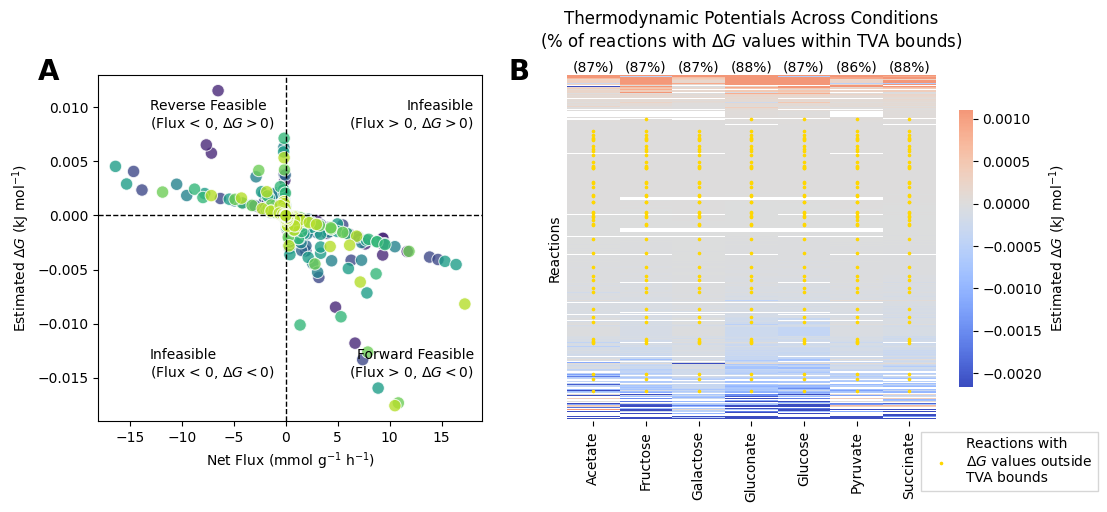

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.cluster.hierarchy as hc
from matplotlib.gridspec import GridSpec

# --- DATA PREPARATION (Assumed Loaded from Previous Steps) ---
# Ideally, you run the data loading and processing steps before this.
# For this script to be standalone runnable, it would need 'df_res' and 'heatmap_data'.
# I will assume variables 'df_res' and 'heatmap_data' are present in the namespace.
# If you are copy-pasting this into a notebook, ensure the data preparation cells are run first.

# --- FIGURE SETUP ---
fig = plt.figure(figsize=(20*0.6, 10*0.5*0.9))
# Create a grid: 1 row, 2 columns. 
# width_ratios controls relative width (heatmap often needs to be wider or narrower).
# wspace controls space between panels.
gs = GridSpec(1, 2, width_ratios=[1, 1.2], wspace=0.2)

# ==========================================
# PANEL A: SCATTER PLOT
# ==========================================
ax_scatter = fig.add_subplot(gs[0])

# Filter for active reactions (non-zero flux)
flux_threshold_plot = 1e-10
df_active = df_res[df_res['Flux'].abs() > flux_threshold_plot].copy()

# Add a label for consistency
df_active['Consistency Label'] = df_active['Consistent'].map({True: 'Consistent', False: 'Inconsistent'})

# Define markers: 'o' for consistent, 'o' for inconsistent (per user request)
markers = {'Consistent': 'o', 'Inconsistent': 'o'}

# Plot Scatter
sns.scatterplot(
    data=df_active, 
    x='Flux', 
    y='Teraflux_dG', 
    hue='Condition', 
    markers=markers,
    palette='viridis', 
    s=80, 
    alpha=0.8,
    ax=ax_scatter,
    legend=False # Handle legend manually to place it well
)

# Add quadrants lines
ax_scatter.axhline(0, color='black', linewidth=1, linestyle='--')
ax_scatter.axvline(0, color='black', linewidth=1, linestyle='--')

# Annotate Quadrants
ax_scatter.text(df_active['Flux'].min() * 0.8, df_active['Teraflux_dG'].max() * 0.7, 
         "Reverse Feasible\n(Flux < 0, $\Delta G > 0$)", 
         fontsize=10, color='k', ha='left')

ax_scatter.text(df_active['Flux'].max() * 1.05, df_active['Teraflux_dG'].min() * 0.85, 
         "Forward Feasible\n(Flux > 0, $\Delta G < 0$)", 
         fontsize=10, color='k', ha='right')

ax_scatter.text(df_active['Flux'].max() * 1.05, df_active['Teraflux_dG'].max() * 0.7, 
         "Infeasible\n(Flux > 0, $\Delta G > 0$)", 
         fontsize=10, color='k', ha='right')

ax_scatter.text(df_active['Flux'].min() * 0.8, df_active['Teraflux_dG'].min() * 0.85, 
         "Infeasible\n(Flux < 0, $\Delta G < 0$)", 
         fontsize=10, color='k', ha='left')

ax_scatter.set_xlabel("Net Flux (mmol g$^{-1}$ h$^{-1}$)")
ax_scatter.set_ylabel("Estimated $\Delta G$ (kJ mol$^{-1}$)")

# Create custom legend for Panel A (Condition Colors)
# We recreate the legend to place it inside or below
handles, labels = ax_scatter.get_legend_handles_labels()
# Filter out the style (Consistency) part if we just want conditions, or keep all.
# Ideally, just show conditions since consistency is all circles now.
# The 'hue' labels are first.
n_conditions = len(df_active['Condition'].unique())
# Taking just the condition handles (plus title maybe)
#ax_scatter.legend(handles[:n_conditions+1], labels[:n_conditions+1], loc='upper left', fontsize=9, title="Condition")

# Panel Label A
ax_scatter.text(-0.1, 1.05, 'A', transform=ax_scatter.transAxes, 
                fontsize=20, fontweight='bold', va='top', ha='right')

#ax_scatter.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ==========================================
# PANEL B: HEATMAP
# ==========================================
ax_heatmap = fig.add_subplot(gs[1])

# Data Prep
heatmap_clean = heatmap_data.dropna(how='all')

# Exclude Glycerol
if 'Glycerol' in heatmap_clean.columns: heatmap_clean = heatmap_clean.drop(columns=['Glycerol'])
elif 'glyc' in heatmap_clean.columns: heatmap_clean = heatmap_clean.drop(columns=['glyc'])

# Sorting Logic
row_means = heatmap_clean.mean(axis=1)
sorted_index = row_means.sort_values(ascending=False).index
heatmap_sorted = heatmap_clean.loc[sorted_index]

# Mask Prep
mask_inconsistent = df_res.pivot(index='Reaction', columns='Condition', values='Consistent')
if 'Glycerol' in mask_inconsistent.columns: mask_inconsistent = mask_inconsistent.drop(columns=['Glycerol'])
elif 'glyc' in mask_inconsistent.columns: mask_inconsistent = mask_inconsistent.drop(columns=['glyc'])
mask_sorted = mask_inconsistent.reindex(sorted_index)
overlay_mask = mask_sorted.replace({True: np.nan, False: 1})

# Plot Heatmap
# Note: cbar_kws needs to target the current axes or figure
sns.heatmap(heatmap_sorted, cmap="coolwarm", center=0, robust=True, 
            cbar_kws={'label': 'Estimated $\Delta G$ (kJ mol$^{-1}$)', 'shrink': .8},
            yticklabels=False, alpha=None, ax=ax_heatmap) 

# Overlay Dots
y_idxs, x_idxs = np.where(overlay_mask == 1)
# scatter on ax_heatmap
ax_heatmap.scatter(x_idxs + 0.5, y_idxs + 0.5, color='gold', s=5, marker='.', 
                   linewidths=1.5, label='Reactions with\n$\Delta G$ values outside\nTVA bounds', alpha=1)

# Annotations (Percentages)
consistency_counts = mask_sorted.sum()
total_counts = mask_sorted.count()
consistency_pcts = (consistency_counts / total_counts * 100)

for idx, col_name in enumerate(heatmap_sorted.columns):
    pct = consistency_pcts[col_name]
    if not np.isnan(pct):
        ax_heatmap.text(idx + 0.5, -0.02, f"({pct:.2g}%)", 
                        ha='center', va='bottom',  color='black',
                        transform=ax_heatmap.transData)

ax_heatmap.set_title("Thermodynamic Potentials Across Conditions\n(% of reactions with $\Delta G$ values within TVA bounds)", pad=20)
ax_heatmap.set_xlabel("")
ax_heatmap.set_ylabel("Reactions")

# Legend for Heatmap
# We use the ax_heatmap to place the legend relative to it
ax_heatmap.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=False, shadow=False, ncol=1)

# Panel Label B
ax_heatmap.text(-0.1, 1.05, 'B', transform=ax_heatmap.transAxes, 
                fontsize=20, fontweight='bold', va='top', ha='right')
ax_heatmap.legend(loc='upper center', bbox_to_anchor=(1.2, -0.01), fancybox=False, shadow=False, ncol=1)

# ==========================================
# FINAL LAYOUT & SAVE
# ==========================================
# Tight layout handles padding between subplots
plt.tight_layout()

# Save
plt.savefig("fig7.svg", bbox_inches='tight')
plt.savefig("fig7.eps", bbox_inches='tight')
plt.savefig("fig7.pdf", bbox_inches='tight')

plt.show()